In [1]:
import pandas as pd

# Load datasets
student_info_df = pd.read_csv('studentInfo.csv')
student_assessment_df = pd.read_csv('studentAssessment.csv')
assessments_df = pd.read_csv('assessments.csv')
vle_df = pd.read_csv('studentVle.csv')  # Interactions with the VLE

# Merge dataframes (adjust based on your final requirements)
merged_assessments_df = pd.merge(student_assessment_df, assessments_df, on='id_assessment')
final_merged_df = pd.merge(merged_assessments_df, student_info_df, on=['id_student', 'code_module', 'code_presentation'])



In [2]:
# Check for missing values in the merged DataFrame
missing_values = final_merged_df.isnull().sum()

# Print columns with missing values
print(missing_values[missing_values > 0])

# Option 1: Impute missing categorical values with the most frequent category
final_merged_df['imd_band'].fillna(final_merged_df['imd_band'].mode()[0], inplace=True)

# Option 2: Drop rows with missing values in key columns (e.g., final_result, score)
final_merged_df.dropna(subset=['final_result', 'score'], inplace=True)

# Option 3: If missing values are not frequent, you can drop the rows


score        173
date        2865
imd_band    7697
dtype: int64


/tmp/ipykernel_124025/787127235.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_merged_df['imd_band'].fillna(final_merged_df['imd_band'].mode()[0], inplace=True)


In [3]:
# One-hot encoding for nominal categorical variables (e.g., gender, region, disability)
final_encoded_df = pd.get_dummies(final_merged_df, columns=['gender', 'region', 'disability'], drop_first=True)

# Check the data after encoding
print(final_encoded_df.head())


   id_assessment  id_student  date_submitted  is_banked  score code_module  \
0           1752       11391              18          0   78.0         AAA   
1           1752       28400              22          0   70.0         AAA   
2           1752       31604              17          0   72.0         AAA   
3           1752       32885              26          0   69.0         AAA   
4           1752       38053              19          0   79.0         AAA   

  code_presentation assessment_type  date  weight  ... region_North Region  \
0             2013J             TMA  19.0    10.0  ...               False   
1             2013J             TMA  19.0    10.0  ...               False   
2             2013J             TMA  19.0    10.0  ...               False   
3             2013J             TMA  19.0    10.0  ...               False   
4             2013J             TMA  19.0    10.0  ...               False   

  region_North Western Region region_Scotland  region_South Ea

In [4]:
# Create a new feature for the average assessment score per student
final_encoded_df['avg_assessment_score'] = final_encoded_df.groupby('id_student')['score'].transform('mean')

# Check the data after feature engineering
print(final_encoded_df[['id_student', 'avg_assessment_score']].head())


   id_student  avg_assessment_score
0       11391                  82.0
1       28400                  66.4
2       31604                  76.0
3       32885                  54.4
4       38053                  68.0


In [5]:
# Create a feature capturing the difference between assessment submission and assessment date
final_encoded_df['submission_delay'] = final_encoded_df['date_submitted'] - final_encoded_df['date']

# Check the new feature
print(final_encoded_df[['id_student', 'submission_delay']].head())


   id_student  submission_delay
0       11391              -1.0
1       28400               3.0
2       31604              -2.0
3       32885               7.0
4       38053               0.0


In [6]:
# Convert date columns to datetime (if applicable)
final_encoded_df['date_submitted'] = pd.to_datetime(final_encoded_df['date_submitted'], errors='coerce')

# Check the data types
print(final_encoded_df.dtypes)


id_assessment                           int64
id_student                              int64
date_submitted                 datetime64[ns]
is_banked                               int64
score                                 float64
code_module                            object
code_presentation                      object
assessment_type                        object
date                                  float64
weight                                float64
highest_education                      object
imd_band                               object
age_band                               object
num_of_prev_attempts                    int64
studied_credits                         int64
final_result                           object
gender_M                                 bool
region_East Midlands Region              bool
region_Ireland                           bool
region_London Region                     bool
region_North Region                      bool
region_North Western Region       

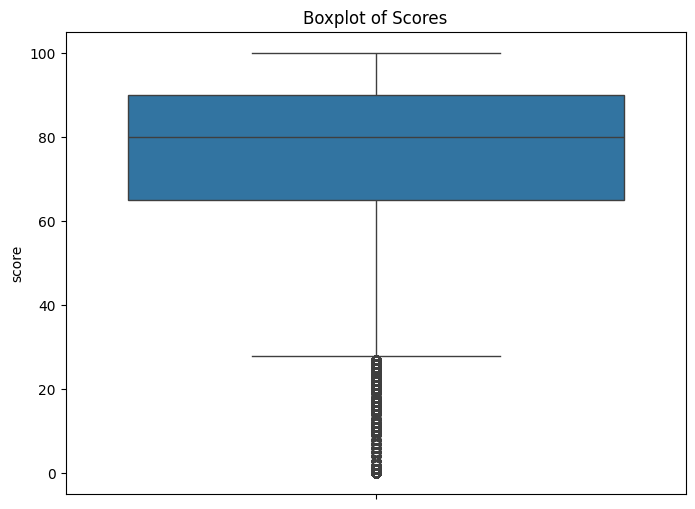

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot to detect outliers in the 'score' column
plt.figure(figsize=(8, 6))
sns.boxplot(final_encoded_df['score'])
plt.title('Boxplot of Scores')
plt.show()

# Optionally, remove outliers based on IQR
Q1 = final_encoded_df['score'].quantile(0.25)
Q3 = final_encoded_df['score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the 'score' column
final_encoded_df = final_encoded_df[(final_encoded_df['score'] >= lower_bound) & (final_encoded_df['score'] <= upper_bound)]


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Scale continuous features like 'studied_credits' and 'score'
final_encoded_df[['studied_credits', 'score', 'avg_assessment_score']] = scaler.fit_transform(final_encoded_df[['studied_credits', 'score', 'avg_assessment_score']])

# Check the scaled data
print(final_encoded_df[['studied_credits', 'score', 'avg_assessment_score']].head())


   studied_credits     score  avg_assessment_score
0             0.35  0.694444              0.798758
1             0.05  0.583333              0.624348
2             0.05  0.611111              0.731677
3             0.05  0.569444              0.490186
4             0.05  0.708333              0.642236


In [11]:
from sklearn.model_selection import train_test_split

# Define features and target for predicting 'final_result' (pass/fail)
X = final_encoded_df.drop(columns=[ 'final_result'])
y = final_encoded_df['final_result']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training set
print(X_train.shape, y_train.shape)


(135940, 31) (135940,)


In [12]:
# Check the final cleaned and preprocessed dataset
print(final_encoded_df.head())


   id_assessment  id_student                date_submitted  is_banked  \
0           1752       11391 1970-01-01 00:00:00.000000018          0   
1           1752       28400 1970-01-01 00:00:00.000000022          0   
2           1752       31604 1970-01-01 00:00:00.000000017          0   
3           1752       32885 1970-01-01 00:00:00.000000026          0   
4           1752       38053 1970-01-01 00:00:00.000000019          0   

      score code_module code_presentation assessment_type  date  weight  ...  \
0  0.694444         AAA             2013J             TMA  19.0    10.0  ...   
1  0.583333         AAA             2013J             TMA  19.0    10.0  ...   
2  0.611111         AAA             2013J             TMA  19.0    10.0  ...   
3  0.569444         AAA             2013J             TMA  19.0    10.0  ...   
4  0.708333         AAA             2013J             TMA  19.0    10.0  ...   

  region_Scotland region_South East Region region_South Region  \
0           Fa

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define features and target for logistic regression (predict 'final_result_encoded')
X = final_encoded_df.drop(columns=[ 'final_result', 'code_module', 'code_presentation'])
y = final_encoded_df['final_result']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


TypeError: Cannot cast DatetimeArray to dtype float64

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target for regression (predict 'score')
X_reg = final_encoded_df.drop(columns=['score', 'final_result_encoded', 'final_result', 'code_module', 'code_presentation'])
y_reg = final_encoded_df['score']

# Split the dataset into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred_reg = rf_model.predict(X_test_reg)

# Evaluate model performance
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Random Forest Regressor Mean Squared Error: {mse}")
print(f"Random Forest Regressor R^2 Score: {r2}")


KeyError: "['final_result_encoded'] not found in axis"

In [17]:
from sklearn.cluster import KMeans
import seaborn as sns

# Define features for clustering
X_clustering = final_encoded_df[['avg_assessment_score', 'studied_credits', 'submission_delay']]

# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_clustering)

# Add cluster labels to the DataFrame
final_encoded_df['kmeans_cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_assessment_score', y='studied_credits', hue='kmeans_cluster', data=final_encoded_df, palette='Set1')
plt.title('K-Means Clustering of Students')
plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [18]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_clustering)

# Add DBSCAN cluster labels to the DataFrame
final_encoded_df['dbscan_cluster'] = dbscan_clusters

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_assessment_score', y='studied_credits', hue='dbscan_cluster', data=final_encoded_df, palette='Set2')
plt.title('DBSCAN Clustering of Students')
plt.show()


ValueError: Input X contains NaN.
DBSCAN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define features and target for logistic regression (predict 'final_result_encoded')
X = final_encoded_df.drop(columns=['final_result_encoded', 'final_result', 'code_module', 'code_presentation'])
y = final_encoded_df['final_result_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print(f"Classification Report:\n {report}")


KeyError: "['final_result_encoded'] not found in axis"

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target for regression (predict 'score')
X_reg = final_encoded_df.drop(columns=['score', 'final_result_encoded', 'final_result', 'code_module', 'code_presentation'])
y_reg = final_encoded_df['score']

# Split the dataset into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred_reg = rf_model.predict(X_test_reg)

# Evaluate model performance
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse}")
print(f"Random Forest Regressor R² Score: {r2}")



KeyError: "['final_result_encoded'] not found in axis"

In [21]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for K-Means clustering
silhouette_kmeans = silhouette_score(X_clustering, clusters)
print(f"K-Means Silhouette Score: {silhouette_kmeans}")

# Calculate the silhouette score for DBSCAN clustering
silhouette_dbscan = silhouette_score(X_clustering, dbscan_clusters)
print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")


NameError: name 'clusters' is not defined

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define features and target for logistic regression (predict 'final_result_encoded')
X = final_encoded_df.drop(columns=['final_result_encoded', 'final_result', 'code_module', 'code_presentation'])
y = final_encoded_df['final_result_encoded']

# Initialize logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Perform 5-fold cross-validation and evaluate accuracy for each fold
cv_scores = cross_val_score(logistic_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation accuracy scores
print(f"Logistic Regression Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}, Standard Deviation: {cv_scores.std():.2f}")


KeyError: "['final_result_encoded'] not found in axis"

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Define features and target for regression (predict 'score')
X_reg = final_encoded_df.drop(columns=['score', 'final_result_encoded', 'final_result', 'code_module', 'code_presentation'])
y_reg = final_encoded_df['score']

# Initialize random forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform 5-fold cross-validation and evaluate Mean Squared Error for each fold
mse_scorer = make_scorer(mean_squared_error)
cv_mse_scores = cross_val_score(rf_model, X_reg, y_reg, cv=5, scoring=mse_scorer)

# Print cross-validation Mean Squared Error scores
print(f"Random Forest Cross-Validation MSE Scores: {cv_mse_scores}")
print(f"Mean CV MSE: {cv_mse_scores.mean():.2f}, Standard Deviation: {cv_mse_scores.std():.2f}")


KeyError: "['final_result_encoded'] not found in axis"

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define features for clustering
X_clustering = final_encoded_df[['avg_assessment_score', 'studied_credits', 'submission_delay']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_clustering)

# Calculate the silhouette score
silhouette_kmeans = silhouette_score(X_clustering, clusters)
print(f"K-Means Silhouette Score: {silhouette_kmeans}")


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [25]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_clustering)

# Calculate the silhouette score for DBSCAN
silhouette_dbscan = silhouette_score(X_clustering, dbscan_clusters)
print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")


ValueError: Input X contains NaN.
DBSCAN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define features and target for regression (predict 'score')
X = final_encoded_df.drop(columns=['score', 'final_result_encoded', 'final_result', 'code_module', 'code_presentation'])
y = final_encoded_df['score']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


KeyError: "['final_result_encoded'] not found in axis"